## Paralogs affected by multi-targeting sgRNAs

**Inputs**:
* Paralog summary (from `process_ensembl_paralogs`)
* Gene sgrna status (from `filter_multi_target_guides`)
* Dropped genes (from `ceres_post_processing`)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

file_paralogs = get_local_data_path(['processed', 'ensembl93'], 'paralog_summary.csv')
file_gene_guide_status = get_local_data_path(['processed', 'depmap19Q1'], 'gene_sgrna_status.csv')
file_dropped_genes = get_local_data_path(['processed', 'depmap19Q1'], 'droppped_genes_11_07_19.csv')

In [2]:
paralog_data = pd.read_csv(file_paralogs, index_col=0).rename(columns={'A1_entrez':'entrez_id'})
paralog_data[:1]

,ensembl_id,symbol,entrez_id,percent_matched_in_paralog,num_paralogs,WGD
0,ENSG00000000003,TSPAN6,7105,0.583673,8,WGD


In [3]:
gene_guide_status_raw = pd.read_csv(file_gene_guide_status)
gene_guide_status_raw[:1]

,entrez_id,multi_target_sgrna
0,1,False


### Paralogs targetted by multi-target guides

In [4]:
# Multi-targeting guides vs. paralog genes
gene_guide_status = pd.merge(gene_guide_status_raw, paralog_data[['num_paralogs', 'entrez_id', 'percent_matched_in_paralog']], 
                                 on='entrez_id', how='left')
gene_guide_status = gene_guide_status.fillna({'num_paralogs':0, 'percent_matched_in_paralog':0})
gene_guide_status = gene_guide_status.assign(is_paralog = gene_guide_status.num_paralogs > 0)
display(gene_guide_status[:1])

,entrez_id,multi_target_sgrna,num_paralogs,percent_matched_in_paralog,is_paralog
0,1,False,0.0,0.0,False


% paralogs multi-targeted: 0.20807425430296478
% singletons multi-targeted: 0.06653708133971292
% all multi-targeted: 0.15484959235310655
Paralogs enriched for multi-targeting? FET: (3.6861008116277048, 2.950261656030519e-156)


Text(0, 0.5, 'Proportion')

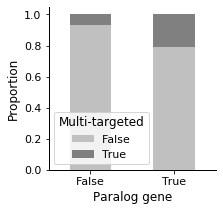

In [5]:
# A multi-target guide could target both a paralog and a singleton
# Counts for each gene type (paralog v. singleton) is number of genes targeted by at least 1 multi-target vs. no multi-targets
ctab = pd.crosstab(gene_guide_status.multi_target_sgrna, gene_guide_status.is_paralog, dropna=False)
print('% paralogs multi-targeted:', ctab.loc[True, True] / ctab.loc[:, True].sum())
print('% singletons multi-targeted:', ctab.loc[True, False] / ctab.loc[:, False].sum())
print('% all multi-targeted:', ctab.loc[True, :].sum() / ctab.sum().sum())
assert(ctab.sum().sum() == gene_guide_status.entrez_id.nunique())
print('Paralogs enriched for multi-targeting? FET:', stats.fisher_exact(ctab))

f, ax = plt.subplots(1, 1, figsize=(3,3))
ctab.T.apply(lambda x: x/x.sum(), axis=1).plot.bar(stacked=True, ax=ax, linewidth=0, rot=0, color=['silver', 'grey'])
ax.legend(title='Multi-targeted'); ax.set_xlabel('Paralog gene'); ax.set_ylabel('Proportion')

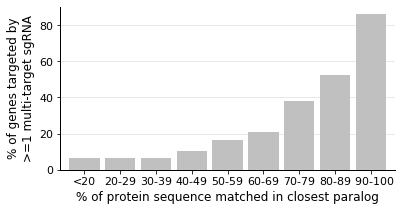

In [6]:
bins = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '  90-100']
seq_id_bins = pd.cut(gene_guide_status.percent_matched_in_paralog, bins=bins, labels=labels, include_lowest=True, right=False)
df = gene_guide_status.assign(seq_id_bin = seq_id_bins)
df = df.groupby(['entrez_id', 'seq_id_bin']).multi_target_sgrna.max().reset_index()

f, ax = plt.subplots(1, 1, figsize=(6,3))
ctab = pd.crosstab(df.multi_target_sgrna, df.seq_id_bin)
ctab.T.apply(lambda x: x/x.sum()*100, axis=1).loc[:, True].plot.bar(stacked=True, ax=ax, linewidth=0, rot=0, 
                                                                    color=['silver'], width=0.85)
ax.grid(axis='y', linewidth=0.5)
ax.set_xlabel('% of protein sequence matched in closest paralog')
_ = ax.set_ylabel('% of genes targeted by\n>=1 multi-target sgRNA')

#plt.savefig('../figures/fig_S1A.svg', bbox_inches='tight', dpi=300)

### Dropped genes

In [8]:
dropped_genes = pd.read_csv(file_dropped_genes)
dropped_genes[:1]

,entrez_id,dropped
0,1,False


% of paralogs that were dropped: 0.07909090909090909
% of singletons that were dropped: 0.019010259505129752


seq_id_bin,<20,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-100
dropped,,,,,,,,,
True,126,13,19,23,56,62,104,152,441
False,6502,1388,1966,2181,1939,1360,698,381,217


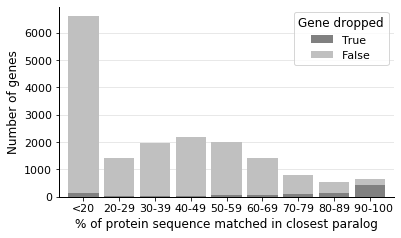

In [9]:
df = pd.merge(dropped_genes, paralog_data[['entrez_id', 'percent_matched_in_paralog']], how='left').fillna({'percent_matched_in_paralog':0})
print('% of paralogs that were dropped:', 
      df[(df.dropped==True) & (df.percent_matched_in_paralog>0)].shape[0]/df[df.percent_matched_in_paralog>0].shape[0])
print('% of singletons that were dropped:', 
      df[(df.dropped==True) & (df.percent_matched_in_paralog==0)].shape[0]/df[df.percent_matched_in_paralog==0].shape[0])

bins = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '  90-100']
seq_id_bins = pd.cut(df.percent_matched_in_paralog, bins=bins, labels=labels, include_lowest=True, right=False)
df = df.assign(seq_id_bin = seq_id_bins)
ctab = pd.crosstab(df.dropped, df.seq_id_bin).iloc[[1,0], :]
display(ctab)

f, ax = plt.subplots(1, 1, figsize=(6,3.5))
ctab.T.plot.bar(stacked=True, ax=ax, linewidth=0, rot=0, color=['grey','silver'], width=0.85)
ax.grid(axis='y', linewidth=0.5)
ax.legend(title='Gene dropped')
ax.set_xlabel('% of protein sequence matched in closest paralog')
ax.set_ylabel('Number of genes')

#plt.savefig('../figures/fig_S1B.svg', bbox_inches='tight', dpi=300)